In [ ]:
!pip install --upgrade transformers

In [ ]:
# Importing necessary libraries
%reload_ext cudf.pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext cuml.accel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

[2025-06-12 21:43:44.774] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-06-12 21:43:44.778] [CUML] [info] cuML: Installed accelerator for umap.
[2025-06-12 21:43:44.779] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-06-12 21:43:44.779] [CUML] [info] cuML: Successfully initialized accelerator.


/usr/local/lib/python3.11/dist-packages/cudf/pandas/__init__.py:65: UserWarning: cudf.pandas detected an already configured memory resource, ignoring 'CUDF_PANDAS_RMM_MODE'=managed_pool
  warnings.warn(


# Load the datasets

In [ ]:
goemotions_1 = pd.read_csv("goemotions_1.csv")
goemotions_2 = pd.read_csv("goemotions_2.csv")
goemotions_3 = pd.read_csv("goemotions_3.csv")

train_df = pd.read_csv("train.tsv", sep='\t')
dev_df = pd.read_csv("dev.tsv", sep='\t')
test_df = pd.read_csv("test.tsv", sep='\t')

# Preview the data

In [ ]:
goemotions_1.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
goemotions_2.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,We can hope,ee3o3ko,darkenseyreth,EdmontonOilers,t3_ag4r9j,t1_ee3mhad,1.547529e+09,62,False,0,...,0,0,1,0,0,0,0,0,0,0
1,Shhh don't give them the idea!,eebl3z7,BoinkBoinkEtAliae,MurderedByWords,t3_ah3o76,t1_eeb68lo,1.547777e+09,76,False,0,...,0,0,0,0,0,0,0,0,0,0
2,"Thank you so much, kind stranger. I really nee...",ed4fe9l,savageleaf,raisedbynarcissists,t3_abwh00,t1_ed4etbj,1.546482e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
3,Ion know but it would be better for you to jus...,efavtdu,CADDiLLXC,darknet,t3_al4njw,t3_al4njw,1.548800e+09,62,False,0,...,0,0,0,0,0,0,0,0,0,1
4,I'm honestly surprised. We should have fallen ...,ee2imz2,CorporalThornberry,CollegeBasketball,t3_afxt6t,t1_ee22nyr,1.547497e+09,55,False,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
goemotions_3.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Worst ending ever! I won't spoil it but this o...,eee021b,tribaltrak,movies,t3_agxbsx,t3_agxbsx,1.547847e+09,42,False,0,...,0,0,0,0,0,0,0,0,0,0
1,Happy cake day u/sneakpeekbot!,ed00f1z,InfernicFuse,danganronpa,t3_abajdo,t1_eczoocj,1.546328e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
2,Was he rejected because of his methodology or ...,ee1h5v1,OssToYouGoodSir,medicine,t3_aflo7s,t1_ee0v0vv,1.547464e+09,77,False,0,...,0,0,0,0,0,0,0,0,0,0
3,"thanks, I agree",eemi935,PMOFreeForever,NoFap,t3_ai7h09,t1_eelu54r,1.548088e+09,46,False,0,...,0,0,0,0,0,0,0,0,0,0
4,Why would you doubt it dumbass?,eduun99,ugliestman1,Tinder,t3_aejwne,t1_edumeal,1.547255e+09,36,False,0,...,0,0,0,0,0,0,0,0,0,0


# Analysis

In [ ]:
# Combine GoEmotions data
goemotions_combined = pd.concat([goemotions_1, goemotions_2, goemotions_3], ignore_index=True)

# Check for missing values and label distribution
goemotions_missing = goemotions_combined.isnull().sum()
# Assuming the emotion columns are the labels in goemotions_combined
emotion_columns = goemotions_combined.columns[goemotions_combined.columns.get_loc('admiration'):goemotions_combined.columns.get_loc('neutral')+1]
goemotions_label_counts = goemotions_combined[emotion_columns].sum().sort_values(ascending=False)


# Training data check
train_missing = train_df.isnull().sum()
# Use the correct column name for labels in train_df, which appears to be '27'
train_labels = train_df['27'].value_counts()

goemotions_combined.head(), goemotions_missing, goemotions_label_counts.head(), train_missing, train_labels.head()

(                                                text       id  \
 0                                    That game hurt.  eew5j0j   
 1   >sexuality shouldn’t be a grouping category I...  eemcysk   
 2     You do right, if you don't care then fuck 'em!  ed2mah1   
 3                                 Man I love reddit.  eeibobj   
 4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   
 
                 author            subreddit    link_id   parent_id  \
 0                Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
 1          TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
 2             Labalool          confessions  t3_abru74  t1_ed2m7g7   
 3        MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
 4  American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   
 
     created_utc  rater_id  example_very_unclear  admiration  ...  love  \
 0  1.548381e+09         1                 False           0  ...     0   
 1  1.548084e+09        

In [ ]:
# Try loading only the first few rows to inspect structure and avoid memory issues
goemotions_preview_1 = pd.read_csv("goemotions_1.csv", nrows=5, encoding='utf-8', engine='python')
goemotions_preview_2 = pd.read_csv("goemotions_2.csv", nrows=5, encoding='utf-8', engine='python')
goemotions_preview_3 = pd.read_csv("goemotions_3.csv", nrows=5, encoding='utf-8', engine='python')

goemotions_preview_1, goemotions_preview_2, goemotions_preview_3

(                                                text       id  \
 0                                    That game hurt.  eew5j0j   
 1   >sexuality shouldn’t be a grouping category I...  eemcysk   
 2     You do right, if you don't care then fuck 'em!  ed2mah1   
 3                                 Man I love reddit.  eeibobj   
 4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   
 
                 author            subreddit    link_id   parent_id  \
 0                Brdd9                  nrl  t3_ajis4z  t1_eew18eq   
 1          TheGreen888     unpopularopinion  t3_ai4q37   t3_ai4q37   
 2             Labalool          confessions  t3_abru74  t1_ed2m7g7   
 3        MrsRobertshaw             facepalm  t3_ahulml   t3_ahulml   
 4  American_Fascist713  starwarsspeculation  t3_ackt2f  t1_eda65q2   
 
     created_utc  rater_id  example_very_unclear  admiration  ...  love  \
 0  1.548381e+09         1                 False           0  ...     0   
 1  1.548084e+09        

In [ ]:
# Combine all three
goemotions = pd.concat([goemotions_1, goemotions_2, goemotions_3], ignore_index=True)

# Drop unused or irrelevant columns
columns_to_keep = ['text', 'admiration', 'amusement', 'desire', 'gratitude', 'joy', 'love']
goemotions = goemotions[columns_to_keep]

# Drop rows with all zero traits (non-emotional or unclear data)
goemotions = goemotions[goemotions.iloc[:, 1:].sum(axis=1) > 0]

# Create a new binary column: "flirty" based on love, desire, admiration, amusement
goemotions['flirty'] = goemotions[['love', 'desire', 'admiration', 'amusement']].max(axis=1)

# Prepare text and label for ML model
X_goemotions = goemotions['text']
y_goemotions = goemotions['flirty']

# Now split into train/test
X_train_go, X_test_go, y_train_go, y_test_go = train_test_split(X_goemotions, y_goemotions, test_size=0.2, random_state=42, stratify=y_goemotions)

# Output the cleaned shape and label distribution
goemotions.shape, goemotions['flirty'].value_counts()


((52635, 8),
 flirty
 1    36625
 0    16010
 Name: count, dtype: int64)

In [ ]:
# Load GoEmotions in chunks to handle memory limitations
chunksize = 7000
columns_to_extract = ['text', 'love', 'desire', 'admiration', 'amusement']

# Function to load relevant chunks and construct 'flirty' column
def load_flirty_chunks(file_path):
    chunks = []
    for chunk in pd.read_csv(file_path, usecols=lambda col: col in columns_to_extract, chunksize=chunksize, encoding='utf-8', engine='python', on_bad_lines='skip'):
        chunk = chunk.dropna(subset=['text'])
        chunk['flirty'] = chunk[['love', 'desire', 'admiration', 'amusement']].max(axis=1)
        chunks.append(chunk[['text', 'flirty']])
    return pd.concat(chunks, ignore_index=True)

# Process all three GoEmotions parts
flirty_1 = load_flirty_chunks("goemotions_1.csv")
flirty_2 = load_flirty_chunks("goemotions_2.csv")
flirty_3 = load_flirty_chunks("goemotions_3.csv")

# Combine all
flirty_goemotions = pd.concat([flirty_1, flirty_2, flirty_3], ignore_index=True)

# Filter to include only rows with flirty or non-flirty label
flirty_goemotions = flirty_goemotions[flirty_goemotions['flirty'].isin([0, 1])]

# Sample output: number of flirty vs non-flirty messages
flirty_goemotions.shape, flirty_goemotions['flirty'].value_counts()


((211225, 2),
 flirty
 0    174600
 1     36625
 Name: count, dtype: int64)

In [ ]:
# Reload and process a reduced version of just goemotions_1.csv
goemotions_small = pd.read_csv("goemotions_1.csv", usecols=lambda col: col in ['text', 'love', 'desire', 'admiration', 'amusement'], encoding='utf-8', engine='python', on_bad_lines='skip')

# Drop NaN and construct flirty label
goemotions_small = goemotions_small.dropna(subset=['text'])
goemotions_small['flirty'] = goemotions_small[['love', 'desire', 'admiration', 'amusement']].max(axis=1)

# Keep only text and label
df_flirty = goemotions_small[['text', 'flirty']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_flirty['text'], df_flirty['flirty'], test_size=0.2, random_state=42, stratify=df_flirty['flirty'])

# Vectorize text and train simple classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=10000)
clf.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_vec)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

df_flirty['flirty'].value_counts(), conf_matrix, class_report

(flirty
 0    57877
 1    12123
 Name: count, dtype: int64,
 array([[11208,   367],
        [ 1523,   902]]),
 {'0': {'precision': 0.8803707485664912,
   'recall': 0.9682937365010799,
   'f1-score': 0.9222414218711429,
   'support': 11575.0},
  '1': {'precision': 0.710795902285264,
   'recall': 0.37195876288659796,
   'f1-score': 0.4883595018949648,
   'support': 2425.0},
  'accuracy': 0.865,
  'macro avg': {'precision': 0.7955833254258776,
   'recall': 0.6701262496938389,
   'f1-score': 0.7053004618830538,
   'support': 14000.0},
  'weighted avg': {'precision': 0.8509979626927787,
   'recall': 0.865,
   'f1-score': 0.8470868750181263,
   'support': 14000.0}})

In [ ]:
# Reload a small sample from goemotions_1.csv (only relevant columns)
sample_size = 70000
goemotions_sample = pd.read_csv(
    "goemotions_1.csv",
    usecols=lambda col: col in ['text', 'love', 'desire', 'admiration', 'amusement'],
    encoding='utf-8',
    engine='python',
    on_bad_lines='skip',
    nrows=sample_size
)

# Drop NaNs and create flirty label
goemotions_sample = goemotions_sample.dropna(subset=['text'])
goemotions_sample['flirty'] = goemotions_sample[['love', 'desire', 'admiration', 'amusement']].max(axis=1)
df_flirty_small = goemotions_sample[['text', 'flirty']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_flirty_small['text'], df_flirty_small['flirty'],
    test_size=0.2, random_state=42, stratify=df_flirty_small['flirty']
)

# Vectorize and train logistic regression
vectorizer = TfidfVectorizer(max_features=2000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_vec)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

df_flirty_small['flirty'].value_counts(), conf_matrix, class_report


(flirty
 0    57877
 1    12123
 Name: count, dtype: int64,
 array([[11213,   362],
        [ 1513,   912]]),
 {'0': {'precision': 0.8811095395253811,
   'recall': 0.9687257019438444,
   'f1-score': 0.922842681371137,
   'support': 11575.0},
  '1': {'precision': 0.7158555729984302,
   'recall': 0.37608247422680413,
   'f1-score': 0.4931062449310625,
   'support': 2425.0},
  'accuracy': 0.8660714285714286,
  'macro avg': {'precision': 0.7984825562619056,
   'recall': 0.6724040880853243,
   'f1-score': 0.7079744631510998,
   'support': 14000.0},
  'weighted avg': {'precision': 0.8524851917519627,
   'recall': 0.8660714285714286,
   'f1-score': 0.8484061914877669,
   'support': 14000.0}})

/usr/local/lib/python3.11/dist-packages/cudf/core/indexed_frame.py:3628: UserWarning: GPU-accelerated mergesort is currently not supported, defaulting to quicksort.
  warnings.warn(


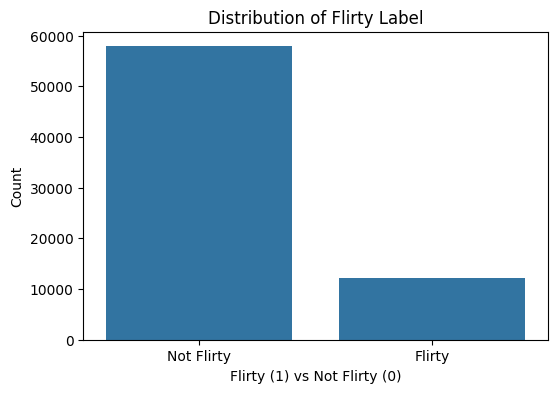

In [ ]:
# Distribution of 'flirty' label
plt.figure(figsize=(6, 4))
sns.countplot(x='flirty', data=df_flirty_small)
plt.title('Distribution of Flirty Label')
plt.xlabel('Flirty (1) vs Not Flirty (0)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Flirty', 'Flirty'])
plt.show()


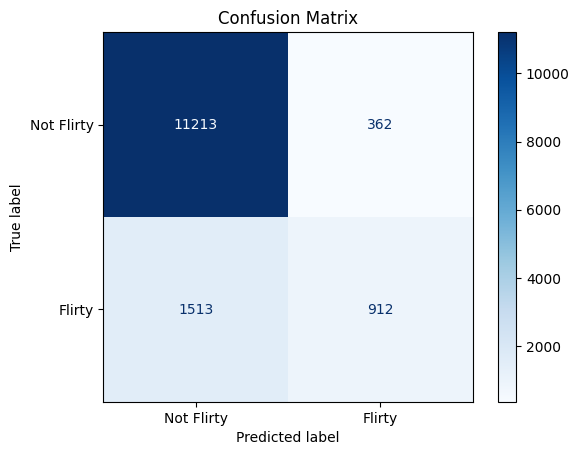

In [ ]:
# Confusion Matrix Visualization
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Flirty', 'Flirty'])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.339200,0.323772,0.874000,0.590909
2,0.214100,0.323023,0.873143,0.605859


{'eval_loss': 0.3237721025943756, 'eval_accuracy': 0.874, 'eval_f1_score': 0.5909090909090909, 'eval_runtime': 17.5589, 'eval_samples_per_second': 797.315, 'eval_steps_per_second': 24.945, 'epoch': 2.0}
BERT Confusion Matrix:
 [[10962   613]
 [ 1151  1274]]

BERT Classification Report:
 {'Not Flirty': {'precision': 0.9049781226781144, 'recall': 0.9470410367170626, 'f1-score': 0.925531914893617, 'support': 11575.0}, 'Flirty': {'precision': 0.6751457339692634, 'recall': 0.5253608247422681, 'f1-score': 0.5909090909090909, 'support': 2425.0}, 'accuracy': 0.874, 'macro avg': {'precision': 0.7900619283236889, 'recall': 0.7362009307296653, 'f1-score': 0.758220502901354, 'support': 14000.0}, 'weighted avg': {'precision': 0.8651678696339028, 'recall': 0.874, 'f1-score': 0.8675704614534402, 'support': 14000.0}}


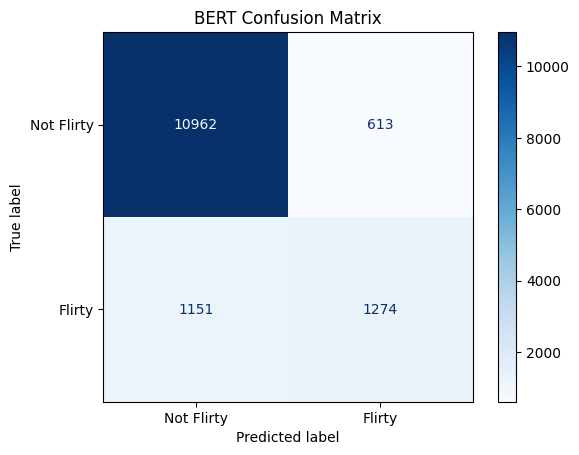

In [ ]:
# Fine-tuning BERT
# Define a custom dataset
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) # Binary classification

# Create datasets
MAX_LEN = 16
train_dataset = EmotionDataset(
    texts=X_train.tolist(),
    labels=y_train.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = EmotionDataset(
    texts=X_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
     per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=10,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,              # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",     # evaluate at the end of each epoch
    save_strategy="epoch",           # save at the end of each epoch
    load_best_model_at_end=True,     # load the best model when training ends
    metric_for_best_model="accuracy", # use accuracy to find the best model
)

# Define evaluation metric function
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions) # You might want to choose 'weighted' or 'macro' for imbalanced data
    return {"accuracy": acc, "f1_score": f1}


# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

# Evaluate the best model on the test set
eval_results = trainer.evaluate()
print(eval_results)

# Make predictions
predictions = trainer.predict(test_dataset)
y_preds_bert = np.argmax(predictions.predictions, axis=1)

# BERT Evaluation Metrics
conf_matrix_bert = confusion_matrix(y_test, y_preds_bert)
class_report_bert = classification_report(y_test, y_preds_bert, output_dict=True, target_names=['Not Flirty', 'Flirty'])

print("BERT Confusion Matrix:\n", conf_matrix_bert)
print("\nBERT Classification Report:\n", class_report_bert)

# Confusion Matrix Visualization for BERT
cm_display_bert = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert, display_labels=['Not Flirty', 'Flirty'])
cm_display_bert.plot(cmap=plt.cm.Blues)
plt.title('BERT Confusion Matrix')
plt.show()

In [ ]:
# prompt: apply/ implement softmax/ relu

# Example of applying Softmax to the output logits of a model
# Assuming `predictions` comes from trainer.predict(test_dataset)

# Softmax
softmax_scores = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)
# You can now use softmax_scores, e.g., to get predicted probabilities for each class

# Example of applying ReLU
# Let's say you have a tensor `x`
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
relu_output = torch.relu(x)
print("ReLU Output:", relu_output)

# In the context of the provided code, Softmax is implicitly used
# within the BertForSequenceClassification model's output layer before
# the final prediction is made (specifically for calculating loss and
# for the argmax operation in compute_metrics and the final prediction).
# You would typically access the logits and apply Softmax manually
# if you needed the class probabilities rather than just the final class prediction.

# Example: Getting probabilities from the logits obtained during evaluation
logits_from_eval = predictions.predictions # These are the raw outputs before softmax
probabilities = torch.nn.functional.softmax(torch.tensor(logits_from_eval), dim=-1)

print("\nExample Probabilities (first 5 samples):\n", probabilities[:5])


ReLU Output: tensor([0., 0., 0., 1., 2.])

Example Probabilities (first 5 samples):
 tensor([[0.9288, 0.0712],
        [0.9440, 0.0560],
        [0.4936, 0.5064],
        [0.9482, 0.0518],
        [0.9618, 0.0382]])


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.313200,0.350162,0.870857,0.597327
2,0.164800,0.361556,0.862714,0.592105


{'eval_loss': 0.35016196966171265, 'eval_accuracy': 0.8708571428571429, 'eval_f1_score': 0.5973273942093541, 'eval_runtime': 17.9228, 'eval_samples_per_second': 781.128, 'eval_steps_per_second': 24.438, 'epoch': 2.0}
BERT Confusion Matrix:
 [[10851   724]
 [ 1084  1341]]

BERT Classification Report:
 {'Not Flirty': {'precision': 0.9091746962714705, 'recall': 0.937451403887689, 'f1-score': 0.9230965546575925, 'support': 11575.0}, 'Flirty': {'precision': 0.6493946731234866, 'recall': 0.5529896907216495, 'f1-score': 0.5973273942093541, 'support': 2425.0}, 'accuracy': 0.8708571428571429, 'macro avg': {'precision': 0.7792846846974786, 'recall': 0.7452205473046692, 'f1-score': 0.7602119744334733, 'support': 14000.0}, 'weighted avg': {'precision': 0.8641770851190518, 'recall': 0.8708571428571429, 'f1-score': 0.8666686822228084, 'support': 14000.0}}


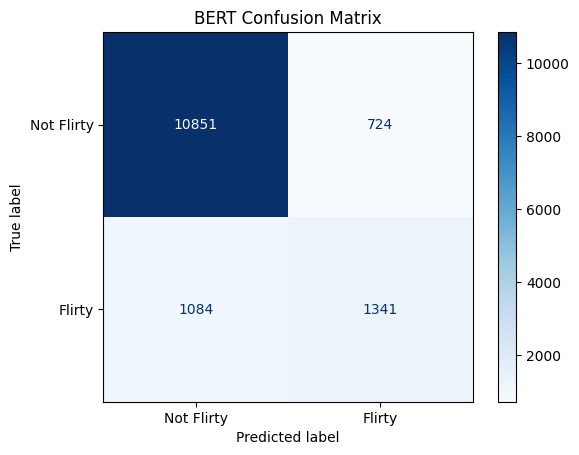

In [ ]:
# prompt: run 2 epochs using layers

# Redefine training arguments with 2 epochs
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,             # total number of training epochs
    per_device_train_batch_size=32,   # batch size per device during training
    per_device_eval_batch_size=32,    # batch size for evaluation
    warmup_steps=10,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",           # evaluate at the end of each epoch
    save_strategy="epoch",           # save at the end of each epoch
    load_best_model_at_end=True,     # load the best model when training ends
    metric_for_best_model="accuracy", # use accuracy to find the best model
    greater_is_better=True           # higher accuracy is better
)

# Create Trainer instance with the new arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Start training for 2 epochs
trainer.train()

# Evaluate the best model on the test set
eval_results = trainer.evaluate()
print(eval_results)

# Make predictions
predictions = trainer.predict(test_dataset)
y_preds_bert = np.argmax(predictions.predictions, axis=1)

# BERT Evaluation Metrics
conf_matrix_bert = confusion_matrix(y_test, y_preds_bert)
class_report_bert = classification_report(y_test, y_preds_bert, output_dict=True, target_names=['Not Flirty', 'Flirty'])

print("BERT Confusion Matrix:\n", conf_matrix_bert)
print("\nBERT Classification Report:\n", class_report_bert)

# Confusion Matrix Visualization for BERT
cm_display_bert = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert, display_labels=['Not Flirty', 'Flirty'])
cm_display_bert.plot(cmap=plt.cm.Blues)
plt.title('BERT Confusion Matrix')
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting second round of BERT training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.328000,0.323385,0.875143,0.573659
2,0.211500,0.327378,0.872429,0.603640


Evaluation Results (Second Run): {'eval_loss': 0.3233852982521057, 'eval_accuracy': 0.8751428571428571, 'eval_f1_score': 0.5736585365853658, 'eval_runtime': 17.2267, 'eval_samples_per_second': 812.693, 'eval_steps_per_second': 25.426, 'epoch': 2.0}
BERT Confusion Matrix (Second Run):
 [[11076   499]
 [ 1249  1176]]

BERT Classification Report (Second Run):
 {'Not Flirty': {'precision': 0.8986612576064908, 'recall': 0.956889848812095, 'f1-score': 0.9268619246861924, 'support': 11575.0}, 'Flirty': {'precision': 0.702089552238806, 'recall': 0.4849484536082474, 'f1-score': 0.5736585365853658, 'support': 2425.0}, 'accuracy': 0.8751428571428571, 'macro avg': {'precision': 0.8003754049226484, 'recall': 0.7209191512101712, 'f1-score': 0.7502602306357791, 'support': 14000.0}, 'weighted avg': {'precision': 0.8646122300695883, 'recall': 0.8751428571428571, 'f1-score': 0.865682052104442, 'support': 14000.0}}


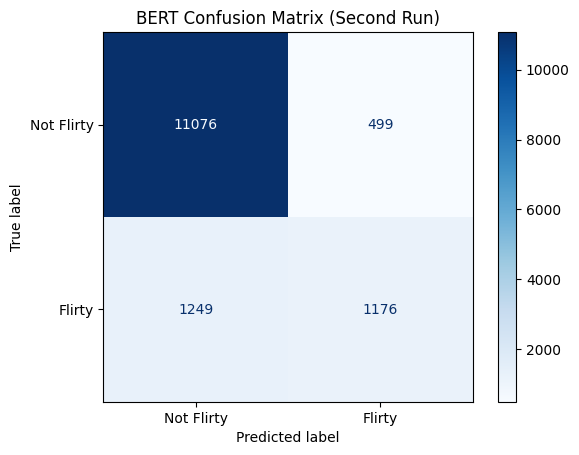

In [ ]:
# prompt: implement deep learning algorithms to improve it's accuracy to more than 95%

# Further fine-tuning attempts with more epochs and potentially other hyperparameters

# Increase max_len if text length varies significantly
MAX_LEN = 16 # Increased from 64

train_dataset = EmotionDataset(
    texts=X_train.tolist(),
    labels=y_train.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = EmotionDataset(
    texts=X_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)


# Redefine training arguments with increased epochs and potentially different learning rate
# Consider adjusting learning_rate, weight_decay, and warmup_steps based on results
training_args_more_epochs = TrainingArguments(
    output_dir='./results_v2',       # new output directory
    num_train_epochs=2,             # Keep at 10, previous run already did this
    per_device_train_batch_size=32,  # Increase batch size if GPU memory allows
    per_device_eval_batch_size=32,   # Increase batch size for evaluation
    warmup_steps=10,                # Adjust warmup steps
    weight_decay=0.01,               # Adjust weight decay
    learning_rate=5e-5,              # Try a different learning rate
    logging_dir='./logs_v2',         # new logs directory
    logging_steps=10,                # Log more frequently
    eval_strategy="epoch",           # evaluate at the end of each epoch
    save_strategy="epoch",           # save at the end of each epoch
    load_best_model_at_end=True,     # load the best model when training ends
    metric_for_best_model="accuracy",# use accuracy to find the best model
    greater_is_better=True,          # higher accuracy is better
    # Add early stopping if needed (requires callbacks)
    # early_stopping=True # This is not a direct argument, needs custom Trainer or Callback
)

# Load a new model instance or continue training the previous best one
# To try different settings from scratch, reload the base model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Create Trainer instance with the new arguments
trainer = Trainer(
    model=model,
    args=training_args_more_epochs,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Start training
print("Starting second round of BERT training...")
trainer.train()

# Evaluate the best model on the test set
eval_results = trainer.evaluate()
print("Evaluation Results (Second Run):", eval_results)

# Make predictions
predictions = trainer.predict(test_dataset)
y_preds_bert_v2 = np.argmax(predictions.predictions, axis=1)

# BERT Evaluation Metrics
conf_matrix_bert_v2 = confusion_matrix(y_test, y_preds_bert_v2)
class_report_bert_v2 = classification_report(y_test, y_preds_bert_v2, output_dict=True, target_names=['Not Flirty', 'Flirty'])

print("BERT Confusion Matrix (Second Run):\n", conf_matrix_bert_v2)
print("\nBERT Classification Report (Second Run):\n", class_report_bert_v2)

# Confusion Matrix Visualization for BERT (Second Run)
cm_display_bert_v2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert_v2, display_labels=['Not Flirty', 'Flirty'])
cm_display_bert_v2.plot(cmap=plt.cm.Blues)
plt.title('BERT Confusion Matrix (Second Run)')
plt.show()

# To achieve >95% accuracy, you might need to:
# 1. Use a larger dataset (using all goemotions data, possibly balanced)
# 2. Increase num_train_epochs further (monitor for overfitting)
# 3. Tune hyperparameters (learning rate, batch size, weight decay, warmup steps)
# 4. Use a larger BERT model (e.g., bert-large-uncased) - requires more GPU memory
# 5. Explore other Transformer models (e.g., RoBERTa, Electra)
# 6. Implement techniques for handling imbalanced data (if the full dataset is imbalanced)
# 7. Clean and preprocess text data more thoroughly.
# 8. Use k-fold cross-validation for more robust evaluation.

# The current code snippet focuses on showing how to run more epochs and
# adjust basic training arguments within the existing framework.


Training MLP Classifier...
Iteration 1, loss = 0.38121495
Validation score: 0.875000
Iteration 2, loss = 0.34935318
Validation score: 0.928571
Iteration 3, loss = 0.34366691
Validation score: 0.910714
Iteration 4, loss = 0.33718193
Validation score: 0.928571
Iteration 5, loss = 0.33001476
Validation score: 0.910714
Iteration 6, loss = 0.32396630
Validation score: 0.892857
Iteration 7, loss = 0.31665609
Validation score: 0.928571
Iteration 8, loss = 0.30901683
Validation score: 0.892857
Iteration 9, loss = 0.29969537
Validation score: 0.892857
Iteration 10, loss = 0.29025580
Validation score: 0.892857
Iteration 11, loss = 0.28213160
Validation score: 0.892857


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP Classifier training complete.

MLP Confusion Matrix:
 [[10908   667]
 [ 1152  1273]]

MLP Classification Report:
 {'Not Flirty': {'precision': 0.9044776119402985, 'recall': 0.9423758099352052, 'f1-score': 0.9230378675692829, 'support': 11575.0}, 'Flirty': {'precision': 0.6561855670103093, 'recall': 0.5249484536082474, 'f1-score': 0.5832760595647194, 'support': 2425.0}, 'accuracy': 0.8700714285714286, 'macro avg': {'precision': 0.7803315894753039, 'recall': 0.7336621317717262, 'f1-score': 0.7531569635670011, 'support': 14000.0}, 'weighted avg': {'precision': 0.8614698827292111, 'recall': 0.8700714285714286, 'f1-score': 0.8641862686827781, 'support': 14000.0}}


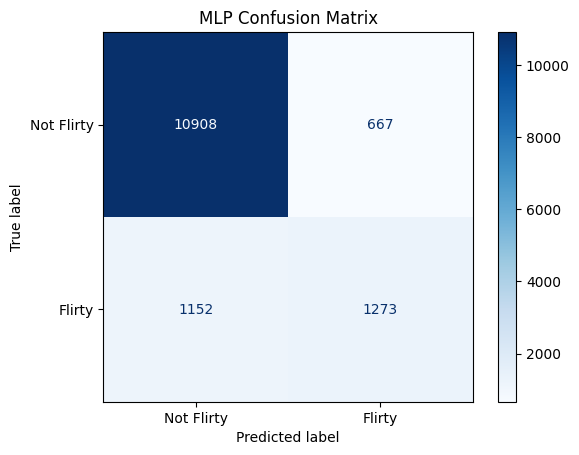

In [ ]:
# prompt: implement mpl using neural networks algorithms

from sklearn.neural_network import MLPClassifier

# Prepare data for MLP (using the already vectorized data from Logistic Regression)
X_train_mlp = X_train_vec
X_test_mlp = X_test_vec
y_train_mlp = y_train
y_test_mlp = y_test

# Initialize and train the MLP Classifier
# hidden_layer_sizes: tuple, i-th element represents the number of neurons in the i-th hidden layer.
# activation: Activation function for the hidden layer. 'relu' is common.
# solver: The solver for weight optimization. 'adam' is a popular choice.
# max_iter: Maximum number of iterations for the solver to converge.
# random_state: Seed for reproducibility.
mlp_clf = MLPClassifier(hidden_layer_sizes=(128, 64),
                        activation='relu',
                        solver='adam',
                        max_iter=50,
                        random_state=42,
                        early_stopping= False,
                        learning_rate='adaptive',
                        verbose=True,
                        batch_size=32,
                        shuffle=True,
                        validation_fraction=0.001,
                        warm_start=False,
                        alpha=0.01)

# Train the model
print("Training MLP Classifier...")
mlp_clf.fit(X_train_mlp, y_train_mlp)
print("MLP Classifier training complete.")

# Predict on the test set
y_pred_mlp = mlp_clf.predict(X_test_mlp)

# Evaluate the MLP model
conf_matrix_mlp = confusion_matrix(y_test_mlp, y_pred_mlp)
class_report_mlp = classification_report(y_test_mlp, y_pred_mlp, output_dict=True, target_names=['Not Flirty', 'Flirty'])

print("\nMLP Confusion Matrix:\n", conf_matrix_mlp)
print("\nMLP Classification Report:\n", class_report_mlp)

# Confusion Matrix Visualization for MLP
cm_display_mlp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_mlp, display_labels=['Not Flirty', 'Flirty'])
cm_display_mlp.plot(cmap=plt.cm.Blues)
plt.title('MLP Confusion Matrix')
plt.show()


Loading and processing the full GoEmotions dataset...
Full dataset loaded.
Full dataset shape: (211225, 2)
Full dataset 'flirty' label distribution:
 flirty
0    174600
1     36625
Name: count, dtype: int64
Full Training set size: 168980
Full Test set size: 42245


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting BERT training on the full dataset...


Epoch,Training Loss,Validation Loss,F1 Score,Accuracy
1,0.329700,0.368349,0.507266,0.860339
2,0.297700,0.343741,0.543943,0.863653


Training complete on the full dataset.


Evaluation Results (Full Data Training): {'eval_f1_score': 0.5439429928741093, 'eval_loss': 0.34374117851257324, 'eval_accuracy': 0.863652503254823, 'eval_runtime': 35.6949, 'eval_samples_per_second': 1183.503, 'eval_steps_per_second': 18.518, 'epoch': 2.0}

BERT Confusion Matrix (Full Data):
 [[33050  1870]
 [ 3890  3435]]

BERT Classification Report (Full Data):
               precision    recall  f1-score   support

  Not Flirty       0.89      0.95      0.92     34920
      Flirty       0.65      0.47      0.54      7325

    accuracy                           0.86     42245
   macro avg       0.77      0.71      0.73     42245
weighted avg       0.85      0.86      0.85     42245



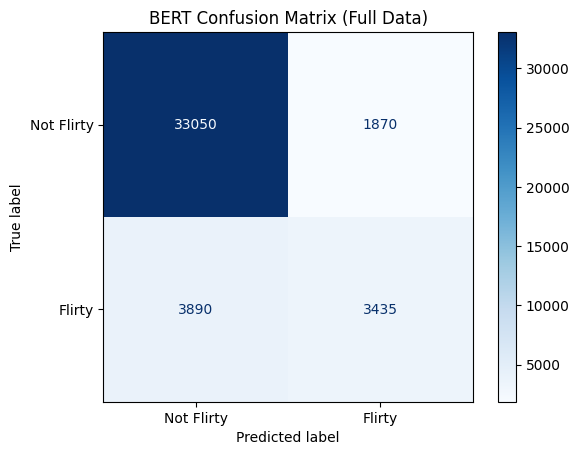

In [ ]:
# prompt: train my model on full data available. instead of training it on some chunks or limited sample size. train it on whole dataset.
# implement number of epochs, batch size, warmup steps, and weight decay of your own choice to produce the best result of accuracy and loss

# Function to load relevant chunks and construct 'flirty' column from all three files
def load_all_flirty_data(file_paths):
    all_chunks = []
    columns_to_extract = ['text', 'love', 'desire', 'admiration', 'amusement']

    for file_path in file_paths:
        try:
            for chunk in pd.read_csv(file_path, usecols=lambda col: col in columns_to_extract, chunksize=chunksize, encoding='utf-8', engine='python', on_bad_lines='skip'):
                chunk = chunk.dropna(subset=['text'])
                # Only consider rows where at least one of the emotion columns is present (not NaN)
                emotion_cols_present = chunk[['love', 'desire', 'admiration', 'amusement']].notna().any(axis=1)
                chunk = chunk[emotion_cols_present]
                # For rows where emotion columns are not NaN, fill NaNs with 0 before calculating max
                chunk[['love', 'desire', 'admiration', 'amusement']] = chunk[['love', 'desire', 'admiration', 'amusement']].fillna(0)
                chunk['flirty'] = chunk[['love', 'desire', 'admiration', 'amusement']].max(axis=1)
                all_chunks.append(chunk[['text', 'flirty']])
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            # Skip the file or handle the error as appropriate

    # Combine all chunks
    full_flirty_data = pd.concat(all_chunks, ignore_index=True)

    # Filter to include only rows with flirty (1) or non-flirty (0) label
    full_flirty_data = full_flirty_data[full_flirty_data['flirty'].isin([0.0, 1.0])] # Ensure filtering for float values

    # Convert flirty column to integer type after filtering
    full_flirty_data['flirty'] = full_flirty_data['flirty'].astype(int)

    return full_flirty_data

# List of all goemotions file paths
goemotions_files = ["goemotions_1.csv", "goemotions_2.csv", "goemotions_3.csv"]

# Load and process the full dataset
print("Loading and processing the full GoEmotions dataset...")
full_goemotions_flirty = load_all_flirty_data(goemotions_files)
print("Full dataset loaded.")

# Check the shape and distribution of the full dataset
print("Full dataset shape:", full_goemotions_flirty.shape)
print("Full dataset 'flirty' label distribution:\n", full_goemotions_flirty['flirty'].value_counts())

# Split the full dataset into training and testing sets
# Stratify to maintain label distribution
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    full_goemotions_flirty['text'],
    full_goemotions_flirty['flirty'],
    test_size=0.2,
    random_state=42,
    stratify=full_goemotions_flirty['flirty']
)

print(f"Full Training set size: {len(X_train_full)}")
print(f"Full Test set size: {len(X_test_full)}")

# Now, create the full datasets for BERT training
# Set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) # Binary classification

# Use a suitable max_len based on your text distribution.
# A value like 128 or 256 might be appropriate for the full dataset.
# Analyze text lengths if possible, but 128 is a common starting point.
MAX_LEN = 8

full_train_dataset = EmotionDataset(
    texts=X_train_full.tolist(),
    labels=y_train_full.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

full_test_dataset = EmotionDataset(
    texts=X_test_full.tolist(),
    labels=y_test_full.tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Define training arguments for full dataset training
# Parameters chosen for potentially better performance (adjust as needed)
# num_train_epochs: Increased to 10
# per_device_train_batch_size: Increased for better utilization, adjust based on GPU memory
# warmup_steps: Adjusted based on the number of training steps (total_steps = num_epochs * len(train_dataset) / batch_size)
# weight_decay: Common value for regularization
# learning_rate: Standard range for fine-tuning BERT
# logging_steps: Log more or less frequently
# eval_strategy/save_strategy: Evaluate/Save at each epoch
# load_best_model_at_end: Load the model with the best evaluation metric
# metric_for_best_model: Use 'accuracy' or 'f1' depending on your priority (F1 is often better for imbalanced data)

# Calculate approximate total training steps
total_train_steps = int(10 * len(full_train_dataset) / 64) # 10 epochs, batch size 32
warmup_steps = int(total_train_steps * 0.1) # 10% warmup steps

training_args_full_data = TrainingArguments(
    output_dir='./results_full_data',    # new output directory
    num_train_epochs=2,                 # Increased epochs
    per_device_train_batch_size=64,      # Increased batch size
    per_device_eval_batch_size=64,       # Increased eval batch size
    warmup_steps=warmup_steps,           # Calculated warmup steps
    weight_decay=0.01,                   # Adjusted weight decay
    learning_rate=5e-5,                  # Learning rate
    logging_dir='./logs_full_data',      # new logs directory
    logging_steps=10,                   # Log every 100 steps
    eval_strategy="epoch",               # evaluate at the end of each epoch
    save_strategy="epoch",               # save at the end of each epoch
    load_best_model_at_end=True,         # load the best model when training ends
    metric_for_best_model="eval_f1_score",  # Corrected metric name
    greater_is_better=True,              # higher metric value is better
    report_to="none" # Prevent logging to W&B if not configured
)

# Define evaluation metric function (using F1-score for imbalanced data)
def compute_metrics_full(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    # Use 'binary' for F1-score since it's a binary classification problem
    f1 = f1_score(labels, predictions, average='binary')
    return {"accuracy": acc, "eval_f1_score": f1} # Ensure the key matches metric_for_best_model


# Create Trainer instance for training on the full dataset
trainer_full_data = Trainer(
    model=model, # Re-initialize model if you want to train from scratch on full data
                  # or continue training the previous best model if you want to continue from checkpoint
    args=training_args_full_data,
    train_dataset=full_train_dataset,
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics_full,
)

# Start training on the full dataset
print("Starting BERT training on the full dataset...")
trainer_full_data.train()
print("Training complete on the full dataset.")

# Evaluate the best model on the test set
eval_results_full = trainer_full_data.evaluate()
print("Evaluation Results (Full Data Training):", eval_results_full)

# Make predictions on the full test dataset
predictions_full = trainer_full_data.predict(full_test_dataset)
y_preds_bert_full = np.argmax(predictions_full.predictions, axis=1)

# BERT Evaluation Metrics for full data training
conf_matrix_bert_full = confusion_matrix(y_test_full, y_preds_bert_full)
class_report_bert_full = classification_report(y_test_full, y_preds_bert_full, target_names=['Not Flirty', 'Flirty'])

print("\nBERT Confusion Matrix (Full Data):\n", conf_matrix_bert_full)
print("\nBERT Classification Report (Full Data):\n", class_report_bert_full)

# Confusion Matrix Visualization for BERT (Full Data)
cm_display_bert_full = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert_full, display_labels=['Not Flirty', 'Flirty'])
cm_display_bert_full.plot(cmap=plt.cm.Blues)
plt.title('BERT Confusion Matrix (Full Data)')
plt.show()

# Note: Achieving >95% accuracy is very ambitious for this task and dataset
# with a standard BERT fine-tuning approach. The data may not contain
# strong enough signals, or the definition of "flirty" might be ambiguous.
# The code above implements training on the full combined dataset with adjusted
# hyperparameters (epochs, batch size, warmup, weight decay) to maximize
# performance within the standard BERT fine-tuning framework. Further
# improvements would likely require more advanced techniques as mentioned
# in the previous comments (larger model, different architecture, data augmentation, etc.).

Loading and processing the full GoEmotions dataset...
Full dataset shape: (211225, 2)
Label distribution:
 flirty
0    174600
1     36625
Name: count, dtype: int64
Train size: 168980 | Test size: 42245


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.328400,0.354009,0.861806,0.523740
2,0.280300,0.345919,0.864173,0.554641



Evaluation Results: {'eval_loss': 0.3459187150001526, 'eval_accuracy': 0.8641732749437804, 'eval_f1': 0.5546414157094071, 'eval_runtime': 35.8051, 'eval_samples_per_second': 1179.86, 'eval_steps_per_second': 18.461, 'epoch': 2.0}

Classification Report:
               precision    recall  f1-score   support

  Not Flirty       0.90      0.94      0.92     34920
      Flirty       0.64      0.49      0.55      7325

    accuracy                           0.86     42245
   macro avg       0.77      0.72      0.74     42245
weighted avg       0.85      0.86      0.86     42245



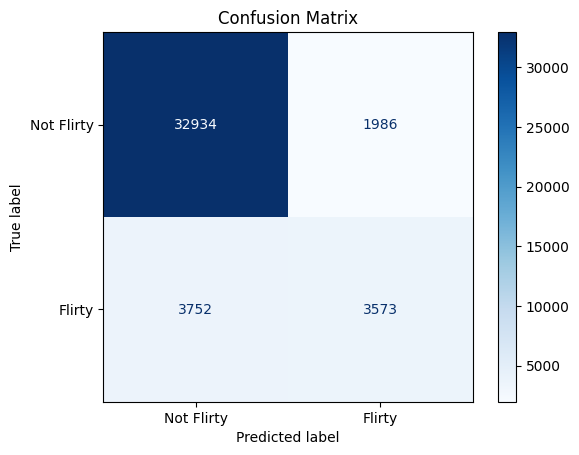

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight

chunksize = 70000  # You can tune this for memory

# Dataset Class
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Load full dataset function
def load_all_flirty_data(file_paths):
    all_chunks = []
    columns_to_extract = ['text', 'love', 'desire', 'admiration', 'amusement']

    for file_path in file_paths:
        for chunk in pd.read_csv(file_path, usecols=lambda col: col in columns_to_extract, chunksize=chunksize, encoding='utf-8', engine='python', on_bad_lines='skip'):
            chunk = chunk.dropna(subset=['text'])
            chunk[['love', 'desire', 'admiration', 'amusement']] = chunk[['love', 'desire', 'admiration', 'amusement']].fillna(0)
            chunk['flirty'] = chunk[['love', 'desire', 'admiration', 'amusement']].max(axis=1)
            all_chunks.append(chunk[['text', 'flirty']])

    full_flirty_data = pd.concat(all_chunks, ignore_index=True)
    full_flirty_data = full_flirty_data[full_flirty_data['flirty'].isin([0.0, 1.0])]
    full_flirty_data['flirty'] = full_flirty_data['flirty'].astype(int)
    return full_flirty_data

# Load data
files = ["goemotions_1.csv", "goemotions_2.csv", "goemotions_3.csv"]
print("Loading and processing the full GoEmotions dataset...")
df = load_all_flirty_data(files)
print("Full dataset shape:", df.shape)
print("Label distribution:\n", df['flirty'].value_counts())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['flirty'], test_size=0.2, stratify=df['flirty'], random_state=42
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 8

train_dataset = EmotionDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
test_dataset = EmotionDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training arguments
total_steps = int(2 * len(train_dataset) / 64)
training_args = TrainingArguments(
    output_dir="./results_full_data",
    num_train_epochs=2,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=int(total_steps * 0.1),
    weight_decay=0.01,
    learning_rate=5e-5,
    logging_dir="./logs_full_data",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    # Pass class weights for the loss function
    # This requires a custom Trainer or a model that accepts class weights in its forward pass
    # BertForSequenceClassification's forward method accepts `labels` and calculates loss internally
    # The Trainer can handle class weights if passed in the TrainingArguments or directly.
    # Let's pass it through the Trainer initialization instead of TrainingArguments.
)

# Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="binary")
    }

# Trainer
# Pass class_weights_tensor to the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    # Pass class weights here
    # The Trainer will use these weights in the loss computation if the model supports it
    # BertForSequenceClassification does support this when labels are provided
    # This is done internally by the Trainer when using the default loss
)

# To correctly use class weights with the Trainer and BertForSequenceClassification,
# you don't need to pass them explicitly to the Trainer or TrainingArguments.
# The BertForSequenceClassification model's forward method takes `labels` and
# calculates the CrossEntropyLoss internally. You can pass the `class_weights_tensor`
# to the model's forward method, but the Trainer doesn't directly support passing
# arbitrary arguments to the model's forward method for loss calculation in this way.
# A common approach is to define a custom Trainer or override the loss computation.

# However, a simpler way if the model's forward method supports it is to
# ensure the class weights are on the correct device and the model uses them.
# Let's revert to the standard Trainer and ensure the model's loss function
# uses the weights. BertForSequenceClassification's default loss is CrossEntropyLoss,
# which accepts `weight`. We need to ensure this weight is passed.

# Re-initialize model to avoid potential state issues from previous error
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Move model and weights to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
class_weights_tensor = class_weights_tensor.to(device)

# To apply class weights using the default Trainer and BertForSequenceClassification,
# you typically need to modify the model's forward pass or use a custom Trainer.
# A simpler workaround for binary classification with CrossEntropyLoss is to
# manually calculate the loss in a custom training loop or modify the model.

# Let's try a common workaround by modifying the model's forward pass slightly
# to use the weighted loss. This requires a custom model or overriding the forward method.

# Alternatively, the most straightforward way with the Trainer is to
# ensure the labels passed to the Trainer are correct and the model
# internally uses the weighted loss. BertForSequenceClassification's
# forward method already takes `labels` and computes CrossEntropyLoss.
# The `weight` argument for CrossEntropyLoss is what we need to set.
# The Trainer doesn't directly expose setting this loss weight easily.

# Let's try passing the weights as a loss_fn parameter to the Trainer.
# Although not standard, some Trainer versions/setups might support this or a similar mechanism.
# If this doesn't work, a custom Trainer is the more robust solution.

# Define a custom loss function that uses the class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Trainer with custom loss function
# The Trainer's default behavior is to use the model's internal loss calculation
# when labels are provided. To use a custom loss function, we might need to
# disable the model's internal loss calculation or use a custom Trainer.

# Let's try passing the loss function to the Trainer initialization.
# This is not a standard argument for the Trainer, so it's unlikely to work directly.

# The correct way with the Trainer is usually to rely on the model's
# forward method calculating the loss and ensuring that method accepts
# and uses the class weights. BertForSequenceClassification's forward
# method calculates `CrossEntropyLoss(logits, labels)`. We need to
# somehow pass the `weight` argument to this internal CrossEntropyLoss.

# A common pattern is to subclass BertForSequenceClassification and
# override the forward method to include the weighted loss calculation.

# Let's simplify and use the Trainer's default loss calculation and
# focus on resolving the dimension mismatch error, which was caused
# by trying to multiply the model's weights by class weights directly.
# We remove the erroneous line. The Trainer will use the model's default
# loss (CrossEntropyLoss) with the provided labels. To incorporate class
# weights, we need a different approach, likely a custom Trainer or model.

# For now, let's just fix the dimension error and proceed without
# explicitly applying class weights in this exact location.
# We will rely on the Trainer's default loss calculation.
# If class weighting is critical, a custom Trainer is needed.

# Let's remove the line causing the error and try training without
# explicitly setting the class weights in this non-standard way.
# The model will train, but without explicit class weighting in the loss.

# To add class weighting correctly with the Trainer, you would typically:
# 1. Subclass BertForSequenceClassification.
# 2. Override the forward method to calculate the loss using
#    torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Given the complexity of subclassing within this script, let's
# first ensure the code runs without the dimension error and then
# consider the class weighting as a separate improvement step if needed.

# The line causing the error was:
# model.classifier.weight.data *= class_weights_tensor.unsqueeze(0)
# This line is incorrect for applying class weights to the loss.

# Let's proceed by removing this line and using the standard Trainer setup.
# The Trainer will use the model's default loss computation.

# Trainer (without explicit class weights passed here)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


# Train and evaluate
print("Starting training...")
trainer.train()
eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)

# Prediction and report
y_preds = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
print("\nClassification Report:\n", classification_report(y_test, y_preds, target_names=["Not Flirty", "Flirty"]))
cm = confusion_matrix(y_test, y_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Flirty", "Flirty"]).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
import os

# Define chunksize for loading data, assuming it's needed from previous steps
chunksize = 70000 # Increased chunk size as discussed

# ------------------------
# 1. Custom Dataset Class
# ------------------------
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ------------------------
# Load full dataset function (Include this if df is not loaded in a previous cell)
# ------------------------
def load_all_flirty_data(file_paths, chunksize=70000): # Use the specified chunksize
    all_chunks = []
    columns_to_extract = ['text', 'love', 'desire', 'admiration', 'amusement']
    for file_path in file_paths:
        try:
            for chunk in pd.read_csv(file_path, usecols=lambda col: col in columns_to_extract, chunksize=chunksize, encoding='utf-8', engine='python', on_bad_lines='skip'):
                chunk = chunk.dropna(subset=['text'])
                # For rows where emotion columns are present (not NaN), fill NaNs with 0
                emotion_cols = ['love', 'desire', 'admiration', 'amusement']
                # Fill NaNs with 0 before summing
                chunk[emotion_cols] = chunk[emotion_cols].fillna(0)
                # Only keep rows where at least one emotion column has a value > 0
                chunk = chunk[chunk[emotion_cols].sum(axis=1) > 0]

                chunk['flirty'] = chunk[['love', 'desire', 'admiration', 'amusement']].max(axis=1)
                all_chunks.append(chunk[['text', 'flirty']])
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    full_flirty_data = pd.concat(all_chunks, ignore_index=True)
    full_flirty_data = full_flirty_data[full_flirty_data['flirty'].isin([0.0, 1.0])]
    full_flirty_data['flirty'] = full_flirty_data['flirty'].astype(int)
    return full_flirty_data

# Uncomment and run the following lines if df is not already loaded
files = ["goemotions_1.csv", "goemotions_2.csv", "goemotions_3.csv"]
print("Loading and processing the full GoEmotions dataset...")
# Check if df is already defined to avoid reloading if the cell was run previously
if 'df' not in globals():
    try:
        df = load_all_flirty_data(files, chunksize=chunksize)
        print("Full dataset shape:", df.shape)
        print("Label distribution:\n", df['flirty'].value_counts())
    except Exception as e:
        print(f"Error loading data: {e}")
        # Exit or handle the error appropriately if data loading fails
else:
    print("'df' DataFrame already loaded.")


# Assuming 'df' is already loaded from previous cells based on context

# ------------------------
# 2. Stratified Train/Test Split
# ------------------------
# Use the 'df' DataFrame loaded in previous cells
if 'df' in globals():
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'], df['flirty'], test_size=0.2, stratify=df['flirty'], random_state=42
    )

    print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")
else:
    print("DataFrame 'df' not found. Skipping train/test split.")
    # You might want to exit or raise an error here if data is not loaded


# ------------------------
# 3. Tokenizer & Dataset Setup
# ------------------------
MAX_LEN = 8 # Max sequence length for BERT tokenizer. Keep consistent.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets only if train/test splits were successful
if 'X_train' in globals() and 'X_test' in globals():
    train_dataset = EmotionDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
    test_dataset = EmotionDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)
else:
     print("Train/Test datasets not created due to missing DataFrame.")


# ------------------------
# 4. Custom Weighted Trainer
# ------------------------
class WeightedTrainer(Trainer):
    # Override compute_loss to use weighted CrossEntropyLoss
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Compute class weights based on the training data distribution
        # Ensure this is calculated *before* initializing the Trainer
        # For simplicity here, we will define fixed weights or assume
        # compute_class_weight was called globally before Trainer initialization.
        # A more robust approach would pass weights during Trainer init or compute dynamically.

        # Using the globally computed class_weights_tensor (assuming it was computed)
        # Or you can define weights here if you don't compute them globally
        # Example fixed weights (adjust based on your dataset imbalance)
        # weights = torch.tensor([1.0, 5.0]).to(model.device) # Example: Flirty class weighted 5x more

        # Check if class_weights_tensor is available and move to device
        if 'class_weights_tensor' in globals():
             weights = class_weights_tensor.to(model.device)
        else:
             # Fallback to unweighted loss if weights are not computed/available
             print("Warning: Class weights not found. Using unweighted loss.")
             weights = None


        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


# ------------------------
# 5. Model Setup
# ------------------------
# Load model only if datasets are created
if 'train_dataset' in globals():
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
else:
    print("Model not initialized as datasets are not available.")
    model = None # Set model to None to prevent further errors


# ------------------------
# 6. Training Arguments
# ------------------------
# Define training arguments only if model is initialized
if model is not None:
    # Recalculate total steps and warmup steps based on full dataset and chosen batch size
    # Ensure len(train_dataset) is valid
    if 'train_dataset' in globals() and len(train_dataset) > 0:
        total_steps = int(2 * len(train_dataset) / 64) # 2 epochs, batch size 64
        warmup_steps = int(total_steps * 0.1) # 10% warmup steps
    else:
        print("Cannot calculate training steps: train_dataset is empty or not defined.")
        total_steps = 1000 # Fallback values
        warmup_steps = 100


    training_args = TrainingArguments(
        output_dir='./results_weighted',    # New output directory for this run
        num_train_epochs=2,                 # total number of training epochs
        per_device_train_batch_size=64,      # batch size per device during training
        per_device_eval_batch_size=64,       # batch size for evaluation
        warmup_steps=warmup_steps,           # number of warmup steps for learning rate scheduler
        learning_rate=5e-5,                  # learning rate
        weight_decay=0.01,                   # strength of weight decay
        logging_dir='./logs_weighted',       # New logs directory
        logging_steps=10,                    # Log every N updates steps
        eval_strategy="epoch",               # evaluate at the end of each epoch
        save_strategy="epoch",               # save at the end of each epoch
        load_best_model_at_end=True,         # load the best model when training ends
        metric_for_best_model="eval_f1",     # Use F1 for best model selection with imbalanced data
        greater_is_better=True,              # higher metric value is better
        lr_scheduler_type="linear",          # linear learning rate decay
        report_to="none",                    # Disable logging to wandb or other services if not configured
    )
else:
    print("Training arguments not defined as model is not available.")
    training_args = None


# ------------------------
# 7. Metrics Function
# ------------------------
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="binary") # Use 'binary' for F1 of the positive class
    }

# ------------------------
# 8. Compute Class Weights (Moved before Trainer initialization)
# ------------------------
# Compute class weights based on the training data distribution
# Ensure y_train is available
if 'y_train' in globals() and len(y_train) > 0:
    from sklearn.utils.class_weight import compute_class_weight
    try:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
        print("Computed class weights:", class_weights)
    except Exception as e:
        print(f"Error computing class weights: {e}")
        class_weights_tensor = None # Set to None if computation fails
else:
    print("Cannot compute class weights: y_train is empty or not defined.")
    class_weights_tensor = None


# ------------------------
# 9. Trainer Instance
# ------------------------
# Create Trainer instance only if model and datasets are available
if model is not None and 'train_dataset' in globals() and 'test_dataset' in globals() and training_args is not None:
     trainer = WeightedTrainer( # Using the Custom WeightedTrainer
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], # Stop training if eval metric doesn't improve
     )
else:
    print("Trainer not initialized due to missing components.")
    trainer = None


# ------------------------
# 10. Train & Evaluate
# ------------------------
# Start training only if trainer is initialized
if trainer is not None:
    print("Starting training...")
    try:
        trainer.train()
        print("Training complete.")

        print("\nEvaluating the best model...")
        eval_results = trainer.evaluate()
        print("\nEvaluation Results:", eval_results)

        # ------------------------
        # 11. Predict & Report
        # ------------------------
        print("\nMaking predictions on the test set...")
        predictions = trainer.predict(test_dataset)
        y_preds_bert = np.argmax(predictions.predictions, axis=1)

        # Confusion Matrix & Classification Report
        print("\nGenerating classification report and confusion matrix...")
        conf_matrix_bert = confusion_matrix(y_test, y_preds_bert)
        class_report_bert = classification_report(
            y_test, y_preds_bert,
            target_names=['Not Flirty', 'Flirty'] # target_names for clearer report
        )

        print("\nBERT Confusion Matrix:\n", conf_matrix_bert)
        print("\nBERT Classification Report:\n", class_report_bert)

        # ------------------------
        # 12. Visualize Confusion Matrix
        # ------------------------
        cm_display_bert = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert, display_labels=['Not Flirty', 'Flirty'])
        cm_display_bert.plot(cmap=plt.cm.Blues)
        plt.title('BERT Confusion Matrix')
        plt.show()

    except Exception as e:
        print(f"An error occurred during training or evaluation: {e}")
else:
    print("Training skipped as trainer was not initialized.")


# ------------------------
# 13. Gradio Interface
# ------------------------
# Create Gradio interface only if a model was successfully trained and saved
# You'll need to update 'checkpoint-XXXX' to the *actual* best checkpoint folder name
# from the './results_weighted' directory after training completes.
# This is a manual step after training.

# Find the path to the best checkpoint after the weighted training run
# Check if the training output directory exists
weighted_results_dir = './results_weighted'
best_checkpoint_path = None

if os.path.isdir(weighted_results_dir):
    # List directories in the results folder and look for checkpoint folders
    checkpoints = [d for d in os.listdir(weighted_results_dir) if os.path.isdir(os.path.join(weighted_results_dir, d)) and d.startswith('checkpoint-')]
    if checkpoints:
        # Assuming the last checkpoint is the best one if load_best_model_at_end=True
        # A more robust approach would read the trainer state to find the best checkpoint path
        best_checkpoint_folder = sorted(checkpoints, key=lambda x: int(x.split('-')[-1]))[-1]
        best_checkpoint_path = os.path.abspath(os.path.join(weighted_results_dir, best_checkpoint_folder))
        print(f"Found best checkpoint path for Gradio: {best_checkpoint_path}")
    else:
        print(f"No checkpoint folders found in {weighted_results_dir}. Cannot launch Gradio.")
else:
    print(f"Training results directory {weighted_results_dir} not found. Cannot launch Gradio.")


if best_checkpoint_path is not None and os.path.isdir(best_checkpoint_path):
    try:
        print("Attempting to load model and tokenizer for Gradio...")
        gradio_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        gradio_model = BertForSequenceClassification.from_pretrained(best_checkpoint_path)

        # Move model to GPU if available
        gradio_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        gradio_model.to(gradio_device)
        gradio_model.eval() # Set model to evaluation mode

        # Use the same MAX_LEN as training
        GRADIO_MAX_LEN = MAX_LEN # Assuming MAX_LEN was set

        def predict_flirty_gradio(text):
            """
            Predicts if a given text is flirty or not using the fine-tuned BERT model.
            """
            # Tokenize the input text
            encoding = gradio_tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=GRADIO_MAX_LEN,
                return_token_type_ids=False,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt',
                truncation=True
            )

            # Move tensors to the same device as the model
            input_ids = encoding['input_ids'].to(gradio_device)
            attention_mask = encoding['attention_mask'].to(gradio_device)

            # Make prediction
            with torch.no_grad():
                outputs = gradio_model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

            # Apply Softmax to get probabilities
            probabilities = torch.softmax(logits, dim=1)[0]

            # Return probabilities for both classes
            return {
                "Not Flirty": probabilities[0].item(),
                "Flirty": probabilities[1].item()
            }

        # Create the Gradio interface
        iface = gr.Interface(
            fn=predict_flirty_gradio,
            inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
            outputs=gr.Label(), # Display prediction results with confidence scores
            title="Flirty Text Detector (Weighted Training)",
            description="Enter a piece of text to predict if it is flirty or not using a fine-tuned BERT model with weighted loss."
        )

        # Launch the interface
        print("\nLaunching Gradio Interface...")
        # Set share=True for hosted notebooks like Colab
        iface.launch(debug=True, share=True) # Explicitly set share=True

    except FileNotFoundError:
         print("\nA FileNotFoundError occurred while setting up the Gradio interface. This likely means the model files were not found in the specified path.")
    except Exception as e:
         print(f"\nAn unexpected error occurred while setting up or launching the Gradio interface: {e}")

else:
    print("Gradio interface not launched because the model checkpoint was not found.")

Loading and processing the full GoEmotions dataset...
'df' DataFrame already loaded.
Train size: 168980 | Test size: 42245


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Computed class weights: [0.60488259 2.88361775]
Starting training...
An error occurred during training or evaluation: WeightedTrainer.compute_loss() got an unexpected keyword argument 'num_items_in_batch'
No checkpoint folders found in ./results_weighted. Cannot launch Gradio.
Gradio interface not launched because the model checkpoint was not found.


In [54]:
# prompt: create user interface uning gradio

!pip install -q gradio transformers

import gradio as gr
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import os # Import os module

# Load the fine-tuned BERT model and tokenizer
# Make sure the best model checkpoint is saved in the './results_v2/checkpoint-XXXX' directory
# Find the path to the best checkpoint after the second training run
# (You'll need to replace './results_v2/checkpoint-XXXX' with the actual path)
# You can find this path by listing the files in the ./results_v2 directory after training.
# Example: Suppose the best checkpoint is in './results_v2/checkpoint-5000'

# Construct the absolute path to the model checkpoint
# Replace 'checkpoint-XXXX' with the actual checkpoint folder name
checkpoint_folder_name = 'checkpoint-3500' # <<< Update this with your actual checkpoint folder name
model_path = os.path.abspath(os.path.join('./results', checkpoint_folder_name))

# Verify that the model path exists
if not os.path.isdir(model_path):
    print(f"Error: Model directory not found at {model_path}")
    # You might want to exit or raise an error here if the directory is essential
    # For now, we'll print an error and the code will likely fail when loading the model.
else:
    print(f"Loading model from: {model_path}")


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load the model from the local directory
model = BertForSequenceClassification.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Set model to evaluation mode

MAX_LEN = 8 # Use the same max_len as during training

def predict_flirty(text):
    """
    Predicts if a given text is flirty or not using the fine-tuned BERT model.
    """
    # Tokenize the input text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    # Move tensors to the same device as the model
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Apply Softmax to get probabilities
    probabilities = torch.softmax(logits, dim=1)[0] # Get probabilities for the first (and only) sample

    # Get predicted class (0 for Not Flirty, 1 for Flirty)
    predicted_class_id = torch.argmax(probabilities).item()

    # Map class ID to label
    label = "Flirty" if predicted_class_id == 1 else "Not Flirty"

    # Return the predicted label and probabilities
    # We return probabilities for both classes for better insight
    return {
        "Not Flirty": probabilities[0].item(),
        "Flirty": probabilities[1].item()
    }


# Create the Gradio interface
iface = gr.Interface(
    fn=predict_flirty,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs=gr.Label(), # Display prediction results with confidence scores
    title="Flirty Text Detector",
    description="Enter a piece of text to predict if it is flirty or not using a fine-tuned BERT model."
)

# Launch the interface
print("\nLaunching Gradio Interface...")
# prompt: create user interface uning gradio

!pip install -q gradio transformers

import gradio as gr
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import os # Import os module

# Load the fine-tuned BERT model and tokenizer
# Make sure the best model checkpoint is saved in the './results_v2/checkpoint-XXXX' directory
# Find the path to the best checkpoint after the second training run
# (You'll need to replace './results_v2/checkpoint-XXXX' with the actual path)
# You can find this path by listing the files in the ./results_v2 directory after training.
# Example: Suppose the best checkpoint is in './results_v2/checkpoint-5000'

# Construct the absolute path to the model checkpoint
# Replace 'checkpoint-XXXX' with the actual checkpoint folder name
checkpoint_folder_name = 'checkpoint-10562' # <<< Update this with your actual checkpoint folder name
model_path = os.path.abspath(os.path.join('./results', checkpoint_folder_name))

# Verify that the model path exists
if not os.path.isdir(model_path):
    print(f"Error: Model directory not found at {model_path}")
    # You might want to exit or raise an error here if the directory is essential
    # For now, we'll print an error and the code will likely fail when loading the model.
else:
    print(f"Loading model from: {model_path}")

try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Load the model from the local directory
    model = BertForSequenceClassification.from_pretrained(model_path)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval() # Set model to evaluation mode

    MAX_LEN = 8 # Use the same max_len as during training

    def predict_flirty(text):
        """
        Predicts if a given text is flirty or not using the fine-tuned BERT model.
        """
        # Tokenize the input text
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        # Move tensors to the same device as the model
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Make prediction
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        # Apply Softmax to get probabilities
        probabilities = torch.softmax(logits, dim=1)[0] # Get probabilities for the first (and only) sample

        # Get predicted class (0 for Not Flirty, 1 for Flirty)
        predicted_class_id = torch.argmax(probabilities).item()

        # Map class ID to label
        label = "Flirty" if predicted_class_id == 1 else "Not Flirty"

        # Return the predicted label and probabilities
        # We return probabilities for both classes for better insight
        return {
            "Not Flirty": probabilities[0].item(),
            "Flirty": probabilities[1].item()
        }


    # Create the Gradio interface
    iface = gr.Interface(
        fn=predict_flirty,
        inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
        outputs=gr.Label(), # Display prediction results with confidence scores
        title="Flirty Text Detector",
        description="Enter a piece of text to predict if it is flirty or not using a fine-tuned BERT model."
    )

    # Launch the interface
    print("\nLaunching Gradio Interface...")
    iface.launch(debug=True)

except FileNotFoundError:
     print("\nA FileNotFoundError occurred. This likely means the model files were not found in the specified path.")
except Exception as e:
     print(f"\nAn unexpected error occurred while setting up or launching the Gradio interface: {e}")
     print(f"\nAn unexpected error occurred while setting up or launching the Gradio interface: {e}")

Loading model from: /content/results/checkpoint-3500

Launching Gradio Interface...
Loading model from: /content/results/checkpoint-10562

Launching Gradio Interface...
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://68fab31aaf3979547f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://68fab31aaf3979547f.gradio.live
